In [32]:
from scipy import stats
import numpy as np
from nilearn import image
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from glob import glob
import nibabel as nib
import os.path as osp
%run /home/grg/git/alfa/nilearn-helper.py
import sys
sys.path.append('/home/grg/git/alfa/')
import multireg_spm12 as mreg
import pandas as pd

### Loading data

In [20]:
# Taking the list of subjects from a previously used design matrix
df = pd.read_excel('/home/grg/spm/designmatrix2.xls')
subjects = df['Subj_ID'].tolist()

found = 0
notfound = []
data = {}
for subject in subjects:
    subject = str(subject)[:5]
    #print subject
    try:
        md = glob('/home/grg/spm/MD/*%s*.nii'%subject)[0]
        jac = glob('/home/grg/spm/Jacobians/*%s*.nii'%subject)[0]
        found += 1
        data[subject] = (md, jac)
    except IndexError:
        print '####', subject, 'not found'
        notfound.append(subject)
        
print found, 'over', len(subjects)
print 'not found:', notfound
    

515 over 515
not found: []


### Building 4D volumes out from input data

In [5]:
md4d_fp = '/home/grg/spm/MD.nii.gz'
jac4d_fp = '/home/grg/spm/Jac.nii.gz'
print 'Building MD 4D volume'
md4d = image.concat_imgs([e[0] for s,e in data.items()])
image.to_filename(md4d_fp)

print 'Building Jacobians 4D volume'
jac4d = image.concat_imgs([e[1] for s,e in data.items()])
jac4d.to_filename(jac4d_fp)

print 'Resampling MD to Jacobian maps'
# Resampling MD to Jacobian maps resolution
image.resample_to_img(jac4d_fp, md4d_fp).to_filename('/home/grg/spm/Jac_r.nii.gz')

MD
(91, 109, 91, 515)


ValueError: bad axis1 argument to swapaxes

### Swapping 4D volumes

So that subjects come as the first axis (faster).
Save results as NumPy arrays on the disk.

Swapping MD
Swapping Jac


### Loading the 4D volumes

In [44]:
mdsw_fp = '/home/grg/spm/MD_sw.npy'
jacrsw_fp = '/home/grg/spm/Jac_r_sw.npy'

md = np.load(mdsw_fp)
jac = np.load(jacrsw_fp)

### Looping over voxels

In [46]:
nb_subjects, dimX, dimY, dimZ = md.shape
print md.shape
pval_list = []
stderr_list = []

method = 'ransac'
print method

for i in xrange(dimX):
    print i
    for j in xrange(dimY):
        for k in xrange(dimZ):
            y,x = md[:,i,j,k], jac[:,i,j,k]


            if method == 'normal':
                slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

            elif method == 'ransac':
                x = x.reshape((x.size, 1))
                y = y.reshape((y.size, 1))
                model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
                model_ransac.fit(x, y)
                sse = np.sum((model_ransac.predict(x) - y) ** 2, axis=0) / float(x.shape[0] - x.shape[1])
                se = np.array([
                        np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(x.T, x))))
                                                                    for i in range(sse.shape[0])
                        ])
                t = model_ransac.estimator_.coef_ / se
                p_value = 2 * (1 - stats.t.cdf(np.abs(t), y.shape[0] - x.shape[1]))
                std_err = se

            stderr_list.append(std_err)
            pval_list.append(p_value)


(515, 109, 91, 91)
ransac
0


ValueError: No inliers found, possible cause is setting residual_threshold (None) too low.

In [18]:
pmap_im = np.array(pval_list).reshape((dimX, dimY, dimZ))
stderr_im = np.array(stderr_list).reshape((dimX, dimY, dimZ))
pmap_im = np.swapaxes(pmap_im, 1,2)
stderr_im = np.swapaxes(stderr_im, 1,2)

ima = image.new_img_like('/home/grg/spm/MD/10134_MD_MNIspace_s.nii', pmap_im)
ima.to_filename('/tmp/p_map.nii.gz')

ima = image.new_img_like('/home/grg/spm/MD/10134_MD_MNIspace_s.nii', stderr_im)
ima.to_filename('/tmp/stderr_map.nii.gz')

### Applying corrections to every map

In [28]:
stderr_im = np.array(nib.load('/tmp/stderr_map.nii.gz').dataobj)
stderr_im = np.swapaxes(stderr_im, 0, 1)
 
for i, subject in enumerate(subjects[:1]):
    subject = str(subject)[:5]
    print subject, i
    try:
        mdfp = glob('/home/grg/spm/MD/*%s*.nii'%subject)[0]
        md = np.array(nib.load(mdfp).dataobj)
        md_corr = md + stderr_im
        img = image.new_img_like(mdfp, md_corr)
        #img.to_filename('/home/grg/spm/MD_corr/%s_MD_corr.nii'%subject)
 
    except IndexError:
        print subject, 'missing'


10070 0


In [40]:
#x, y  = vox1[0], vox1[1]

x = x.reshape((x.size,1))
y = y.reshape((y.size,1))
print x.shape, y.shape

from sklearn import linear_model
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(x, y)
                 
#line_y_ransac = model_ransac.predict(x)
#model_ransac.estimator_.intercept_

(515, 1) (515, 1)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

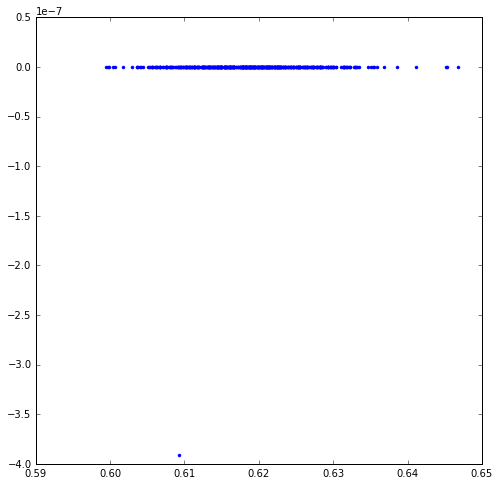

In [49]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y, '.')
#ax.plot(x, x*slope + intercept, '-')
#print p_value
#line_y_ransac = model_ransac.predict(x)
#ax.plot(x, line_y_ransac, '-')
fig.show()

In [41]:
sse = np.sum((model_ransac.predict(x) - y) ** 2, axis=0) / float(x.shape[0] - x.shape[1])
se = np.array([
    np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(x.T, x))))
                                            for i in range(sse.shape[0])
            ])

t = model_ransac.estimator_.coef_ / se
p = 2 * (1 - stats.t.cdf(np.abs(t), y.shape[0] - x.shape[1]))
print t, p

[[-inf]] [[ 0.]]


In [35]:
pval_list = np.load('/tmp/pval_list.npy')
stderr_list = np.load('/tmp/stderr_list.npy')
len(pval_list), len(stderr_list)
dimX, dimY, dimZ = 109, 91, 91
nib.save(np.array(pval_list).reshape((dimX, dimY, dimZ))

(902629, 902629, 902629)

Saving to... /tmp/tmp70Vf2D.png


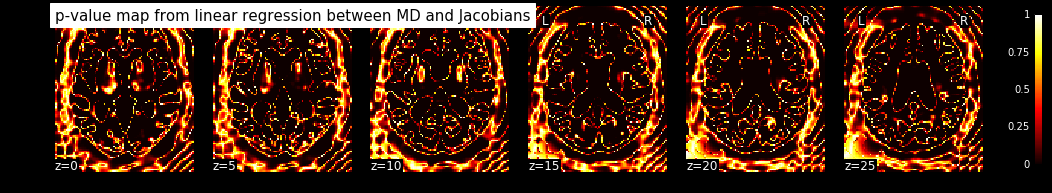

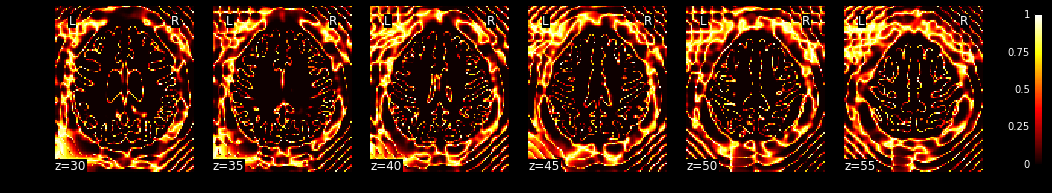

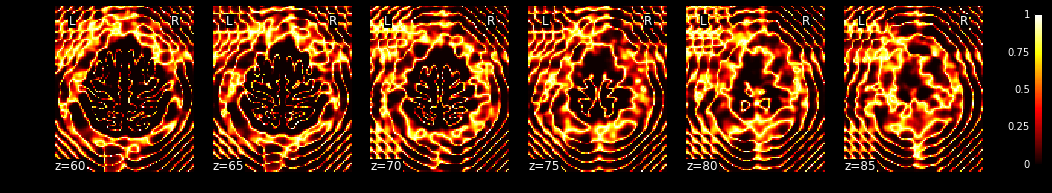

In [78]:
%run /home/grg/git/alfa/nilearn-helper.py
sample_fp = '/home/grg/spm/MD/10013_MD_MNIspace_s.nii'
img = np.array(nib.load('/tmp/p_map2.nii.gz').dataobj)
img = np.swapaxes(img, 0, 1)
mask_fp = '/home/grg/spm/MNI_T1_brain_mask.nii'
mask = np.array(nib.load(mask_fp).dataobj)
#img[mask==0] = 0
plot_stat_map(image.new_img_like(sample_fp, img), bg_img=sample_fp, start =0, end=60, step=5, row_l=6, title='p-value map from linear regression between MD and Jacobians')


In [72]:
img2

array([  1.02456460e-03,   6.33586596e-03,   2.27192730e-02, ...,
         5.20993703e-05,   2.49204733e-06,   1.82213222e-06])